#1. Load and preprocess data

In [ ]:
!pip install pyECLAT

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import numpy
import csv
import matplotlib.pyplot as plt
import time
from wordcloud import WordCloud
from pyECLAT import ECLAT
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
# Đọc dataFrame
df = pd.read_csv('Market Basket Analysis 5.csv', sep = 'delimiter', header = None)
df

,0
0,"1/1/2000yogurt, pork, sandwich bags, lunch mea..."
1,"1/1/2000toilet paper, shampoo, hand soap, waff..."
2,"2/1/2000soda, pork, soap, ice cream, toilet pa..."
3,"2/1/2000cereals, juice, lunch meat, soda, toil..."
4,"2/1/2000sandwich loaves, pasta, tortillas, mix..."
...,...
1494,"22/2/2002sugar, beef, sandwich bags, hand soap..."
1495,"23/2/2002coffee/tea, dinner rolls, lunch meat,..."
1496,"24/2/2002beef, lunch meat, eggs, poultry, vege..."
1497,"25/2/2002sandwich bags, ketchup, milk, poultry..."


In [ ]:
# Xử lí chuỗi thời gian ở đầu mỗi row
df[df.columns[0]] = df[df.columns[0]].str.replace(r'\d{1,2}/\d{1,2}/\d{4}', '', regex=True)

In [ ]:
df

,0
0,"yogurt, pork, sandwich bags, lunch meat, all- ..."
1,"toilet paper, shampoo, hand soap, waffles, veg..."
2,"soda, pork, soap, ice cream, toilet paper, din..."
3,"cereals, juice, lunch meat, soda, toilet paper..."
4,"sandwich loaves, pasta, tortillas, mixes, hand..."
...,...
1494,"sugar, beef, sandwich bags, hand soap, paper t..."
1495,"coffee/tea, dinner rolls, lunch meat, spaghett..."
1496,"beef, lunch meat, eggs, poultry, vegetables, t..."
1497,"sandwich bags, ketchup, milk, poultry, cheeses..."


In [ ]:
# Xử lí các khoảng trắng
df[df.columns[0]] = df[df.columns[0]].str.rstrip(', ')
# Tách chuỗi sang danh sách
df = df[df.columns[0]].str.split(', ', expand=True)
df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,yogurt,pork,sandwich bags,lunch meat,all- purpose,flour,soda,butter,vegetables,beef,...,None,None,None,None,None,None,None,None,None,None
1,toilet paper,shampoo,hand soap,waffles,vegetables,cheeses,mixes,milk,sandwich bags,laundry detergent,...,None,None,None,None,None,None,None,None,None,None
2,soda,pork,soap,ice cream,toilet paper,dinner rolls,hand soap,spaghetti sauce,milk,ketchup,...,spaghetti sauce,pork,vegetables,cheeses,eggs,vegetables,vegetables,None,None,None
3,cereals,juice,lunch meat,soda,toilet paper,all- purpose,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,sandwich loaves,pasta,tortillas,mixes,hand soap,toilet paper,vegetables,vegetables,paper towels,vegetables,...,all- purpose,soda,yogurt,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,sugar,beef,sandwich bags,hand soap,paper towels,paper towels,all- purpose,beef,fruits,coffee/tea,...,beef,cereals,juice,poultry,sugar,soap,None,None,None,None
1495,coffee/tea,dinner rolls,lunch meat,spaghetti sauce,pasta,vegetables,cereals,dinner rolls,soap,milk,...,None,None,None,None,None,None,None,None,None,None
1496,beef,lunch meat,eggs,poultry,vegetables,tortillas,beef,beef,individual meals,dishwashing liquid/detergent,...,vegetables,pork,None,None,None,None,None,None,None,None
1497,sandwich bags,ketchup,milk,poultry,cheeses,soap,toilet paper,yogurt,beef,waffles,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Tạo bản copy cho việc EDA data
df_copy = df.copy(deep=True)

In [ ]:
# Tạo list các transaction từ các row trong df và lưu ý 1 item kh được xuất hiện quá 2 lần trong 1 transaction
list_of_lists = df.apply(lambda row: list(set(value for value in row if value not in (' ', None))), axis=1).values.tolist()

# Chuyển đổi lại thành dataframe để cho vào thư viện
transactions = list(list_of_lists)
data = pd.DataFrame(transactions)
data

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,yogurt,butter,ice cream,soap,dinner rolls,flour,all- purpose,sandwich bags,shampoo,mixes,...,None,None,None,None,None,None,None,None,None,None
1,yogurt,hand soap,waffles,milk,laundry detergent,shampoo,sandwich bags,mixes,toilet paper,individual meals,...,None,None,None,None,None,None,None,None,None,None
2,eggs,bagels,dinner rolls,shampoo,toilet paper,vegetables,cheeses,ketchup,hand soap,spaghetti sauce,...,soap,laundry detergent,lunch meat,None,None,None,None,None,None,None
3,juice,all- purpose,cereals,toilet paper,soda,lunch meat,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,eggs,dinner rolls,individual meals,mixes,toilet paper,vegetables,hand soap,waffles,spaghetti sauce,all- purpose,...,paper towels,flour,tortillas,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,dinner rolls,shampoo,mixes,dishwashing liquid/detergent,fruits,cheeses,sugar,hand soap,juice,all- purpose,...,paper towels,sandwich bags,None,None,None,None,None,None,None,None
1495,eggs,cheeses,hand soap,spaghetti sauce,dinner rolls,pasta,soap,milk,coffee/tea,cereals,...,None,None,None,None,None,None,None,None,None,None
1496,sugar,eggs,yogurt,bagels,hand soap,juice,soap,dinner rolls,paper towels,shampoo,...,poultry,None,None,None,None,None,None,None,None,None
1497,yogurt,sugar,ketchup,waffles,soap,spaghetti sauce,milk,paper towels,all- purpose,sandwich bags,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Chuyển sang dạng TID của ECLAT chạy
df_transposed = df.T
df_vertical = df_transposed.reset_index().melt(id_vars='index', value_name='Item', var_name='TransactionID')
df_vertical.columns = ['TransactionIndex', 'TransactionID', 'Item']

# Lọc bớt giá item 'None'
df_filtered = df_vertical[df_vertical['Item'].notna()]

# Nhóm theo sản phẩm
df_result = df_filtered.groupby('Item')['TransactionID'].apply(list).reset_index()
df_result = df_result.drop('TransactionIndex', axis=1, errors='ignore')

# Loại bỏ các giao dịch trùng trong mỗi sản phẩm
df_result['TransactionID'] = df_result['TransactionID'].apply(lambda x: list(set(x)))

df_result

,Item,TransactionID
0,all- purpose,"[0, 3, 4, 5, 6, 12, 20, 22, 23, 24, 26, 27, 28..."
1,aluminum foil,"[0, 1, 5, 12, 14, 18, 19, 22, 25, 30, 31, 32, ..."
2,bagels,"[2, 5, 9, 10, 11, 12, 14, 17, 18, 20, 21, 22, ..."
3,beef,"[0, 6, 9, 15, 18, 19, 25, 31, 33, 38, 39, 41, ..."
4,butter,"[0, 5, 11, 14, 18, 19, 23, 25, 26, 27, 28, 35,..."
5,cereals,"[1, 2, 3, 5, 13, 14, 15, 16, 21, 22, 25, 27, 3..."
6,cheeses,"[1, 2, 7, 9, 10, 13, 14, 15, 19, 21, 22, 23, 2..."
7,coffee/tea,"[5, 8, 9, 10, 17, 18, 19, 22, 23, 25, 32, 33, ..."
8,dinner rolls,"[0, 2, 4, 10, 13, 15, 25, 26, 28, 30, 31, 35, ..."
9,dishwashing liquid/detergent,"[1, 5, 6, 8, 9, 10, 15, 19, 22, 24, 42, 43, 46..."


# 2. EDA

Số sản phẩm khách hàng mua trong mỗi giao dịch.

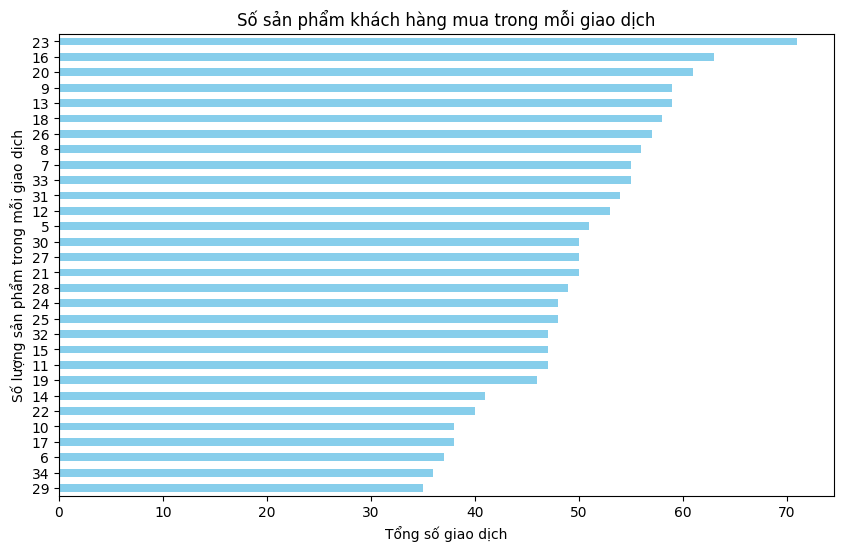

In [ ]:
# Print the length of each row excluding None values
# Calculate the row lengths excluding None and ' '
row_lengths = df_copy.apply(lambda row: sum(1 for value in row if value not in (None, ' ')), axis=1)
length_counts = row_lengths.value_counts().sort_index()
length_counts_sorted = length_counts.sort_values()

# Plot the bar plot
plt.figure(figsize=(10, 6))
length_counts_sorted.plot(kind='barh', color='skyblue')
plt.title('Số sản phẩm khách hàng mua trong mỗi giao dịch')
plt.xlabel('Tổng số giao dịch')
plt.ylabel('Số lượng sản phẩm trong mỗi giao dịch')
plt.show()

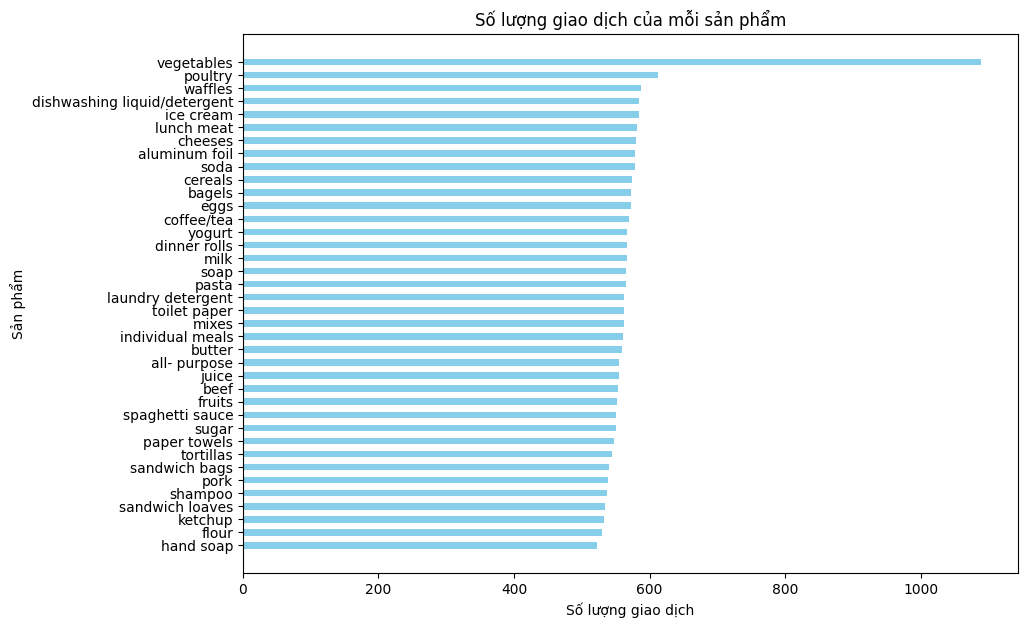

In [ ]:
# Đếm tidset của mỗi mặt hàng
itemset_lengths = df_result['TransactionID'].apply(lambda x: len(x))
df_result['count'] = itemset_lengths # Tạo một series độ dài của TransID
df_result = df_result.sort_values(by='count')

plt.figure(figsize=(10, 7))

# Plot xem item nào có độ dài TransID nhiều nhất, descending
y = range(len(df_result['Item']))
plt.barh(y, df_result['count'], height=0.5, color='skyblue')
plt.yticks(y, df_result['Item'])
plt.title('Số lượng giao dịch của mỗi sản phẩm')
plt.xlabel('Số lượng giao dịch')
plt.ylabel('Sản phẩm')

plt.show()

WordCloud để xem cái nào là phổ biến nhất.

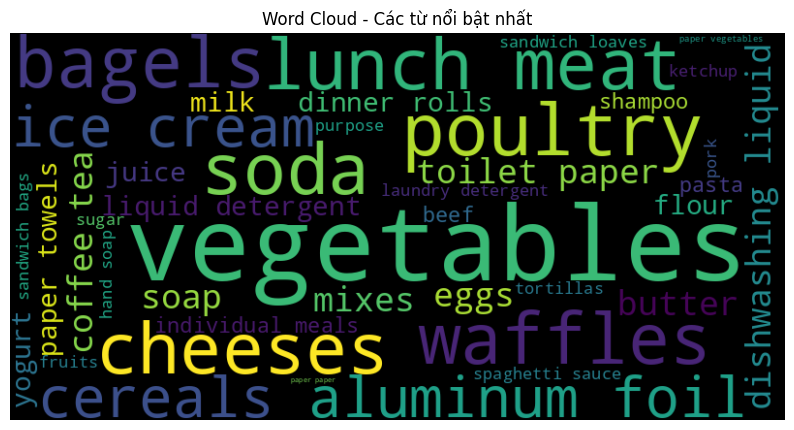

In [ ]:
from wordcloud import WordCloud
# Combine all words from all columns into a single Series
all_words = df_copy.apply(lambda col: ' '.join(col.dropna()), axis=1)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(all_words))

# Plot the WordCloud image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Các từ nổi bật nhất')
plt.show()

# 3. ECLAT

In [ ]:
# Tạo instance eclat
eclat = ECLAT(data=data, verbose=True)

# Chạy thuật toán eclat
start = time.time()

ECLAT_indexes, ECLAT_supports = eclat.fit(min_support=0.2,
                                          min_combination=1,
                                          max_combination=3,
                                          separator=' & ',
                                          verbose=True)

end = time.time()
time_eclat = end - start

100%|██████████| 39/39 [00:00<00:00, 1595.82it/s]


Combination 1 by 1


38it [00:00, 117.84it/s]


Combination 2 by 2


703it [00:03, 187.15it/s]


Combination 3 by 3


8436it [00:49, 169.42it/s]


In [ ]:
frequent_itemsets_eclat = pd.DataFrame(ECLAT_supports.items(), columns=['itemsets', 'support'])
frequent_itemsets_eclat

,itemsets,support
0,eggs,0.381588
1,bagels,0.382255
2,dinner rolls,0.378252
3,shampoo,0.358239
4,individual meals,0.374249
...,...,...
70,vegetables & laundry detergent,0.304203
71,vegetables & sandwich bags,0.284857
72,vegetables & tortillas,0.275517
73,vegetables & aluminum foil,0.309540


In [ ]:
# Xử lí thêm để có thể xử dụng mlxtend để thể hiện đánh giá của các luật kết hợp
new_column = []
for row in frequent_itemsets_eclat['itemsets']:
    r = row.split('&')
    r = tuple(i.strip() for i in r)
    new_column.append(r)
frequent_itemsets_eclat['itemsets'] = pd.Series(new_column)

In [ ]:
# Mình chỉ quan tâm tới cái support, confidence, lift thôi
rules_eclat = association_rules(frequent_itemsets_eclat, metric="support", min_threshold=0.2).sort_values(by ='lift', ascending=False)

In [ ]:
rules_eclat.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
37,(vegetables),(yogurt),0.726484,0.378252,0.308205,0.424242,1.121586,0.033411,1.079878,0.396341
36,(yogurt),(vegetables),0.378252,0.726484,0.308205,0.814815,1.121586,0.033411,1.476985,0.174356
1,(vegetables),(eggs),0.726484,0.381588,0.310874,0.427916,1.121408,0.033656,1.080981,0.395823
0,(eggs),(vegetables),0.381588,0.726484,0.310874,0.814685,1.121408,0.033656,1.475953,0.175067
65,(vegetables),(laundry detergent),0.726484,0.375584,0.304203,0.418733,1.114885,0.031347,1.074233,0.376749
...,...,...,...,...,...,...,...,...,...,...
69,(vegetables),(tortillas),0.726484,0.363576,0.275517,0.379247,1.043103,0.011385,1.025246,0.151078
49,(vegetables),(pork),0.726484,0.359573,0.267512,0.368228,1.024069,0.006287,1.013699,0.085932
48,(pork),(vegetables),0.359573,0.726484,0.267512,0.743970,1.024069,0.006287,1.068297,0.036700
43,(vegetables),(coffee/tea),0.726484,0.379586,0.282188,0.388430,1.023297,0.006425,1.014460,0.083238


#4. Experiment and Comparing

## 1. So với giải thuật apriori

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_exp = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
df_exp.head()

,all- purpose,aluminum foil,bagels,beef,butter,cereals,cheeses,coffee/tea,dinner rolls,dishwashing liquid/detergent,...,shampoo,soap,soda,spaghetti sauce,sugar,toilet paper,tortillas,vegetables,waffles,yogurt
0,True,True,False,True,True,False,False,False,True,False,...,True,True,True,False,False,False,False,True,False,True
1,False,True,False,False,False,True,True,False,False,True,...,True,False,False,False,False,True,True,True,True,True
2,False,False,True,False,False,True,True,False,True,False,...,True,True,True,True,False,True,False,True,False,False
3,True,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
4,True,False,False,False,False,False,False,False,True,False,...,False,False,True,True,False,True,True,True,True,True


In [ ]:
start = time.time()

frequent_itemsets_apriori = apriori(df_exp, min_support=0.2, use_colnames = True)

end = time.time()
time_apriori = end - start
print("Thời gian chạy Apriori: ", time_apriori)

Thời gian chạy Apriori:  0.01523733139038086


In [ ]:
frequent_itemsets_apriori['length'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x))

In [ ]:
rules_apriori = association_rules(frequent_itemsets_apriori, metric="support", min_threshold=0.2).sort_values(by = 'lift', ascending=False)
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
73,(vegetables),(yogurt),0.726484,0.378252,0.308205,0.424242,1.121586,0.033411,1.079878,0.396341
72,(yogurt),(vegetables),0.378252,0.726484,0.308205,0.814815,1.121586,0.033411,1.476985,0.174356
20,(eggs),(vegetables),0.381588,0.726484,0.310874,0.814685,1.121408,0.033656,1.475953,0.175067
21,(vegetables),(eggs),0.726484,0.381588,0.310874,0.427916,1.121408,0.033656,1.080981,0.395823
36,(vegetables),(laundry detergent),0.726484,0.375584,0.304203,0.418733,1.114885,0.031347,1.074233,0.376749
...,...,...,...,...,...,...,...,...,...,...
69,(vegetables),(tortillas),0.726484,0.363576,0.275517,0.379247,1.043103,0.011385,1.025246,0.151078
49,(vegetables),(pork),0.726484,0.359573,0.267512,0.368228,1.024069,0.006287,1.013699,0.085932
48,(pork),(vegetables),0.359573,0.726484,0.267512,0.743970,1.024069,0.006287,1.068297,0.036700
15,(vegetables),(coffee/tea),0.726484,0.379586,0.282188,0.388430,1.023297,0.006425,1.014460,0.083238


## 2. With FP-Growth

In [ ]:
start = time.time()

frequent_itemsets_fpg = fpgrowth(df_exp, min_support=0.2, use_colnames=True)

end = time.time()

time_fpg = end - start
print("Thời gian chạy FP-growth: ", time_fpg)

Thời gian chạy FP-growth:  0.3134427070617676


In [ ]:
frequent_itemsets_fpg['length'] = frequent_itemsets_fpg['itemsets'].apply(lambda x: len(x))

In [ ]:
frequent_itemsets_fpg

,support,itemsets,length
0,0.726484,(vegetables),1
1,0.389593,(ice cream),1
2,0.388259,(lunch meat),1
3,0.386258,(aluminum foil),1
4,0.386258,(soda),1
...,...,...,...
70,0.287525,"(pasta, vegetables)",2
71,0.285524,"(paper towels, vegetables)",2
72,0.282188,"(coffee/tea, vegetables)",2
73,0.284189,"(fruits, vegetables)",2


In [ ]:
rules_fpg = association_rules(frequent_itemsets_fpg, metric="support", min_threshold=0.2).sort_values(by = 'lift', ascending=False)
rules_fpg

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
8,(yogurt),(vegetables),0.378252,0.726484,0.308205,0.814815,1.121586,0.033411,1.476985,0.174356
9,(vegetables),(yogurt),0.726484,0.378252,0.308205,0.424242,1.121586,0.033411,1.079878,0.396341
55,(vegetables),(eggs),0.726484,0.381588,0.310874,0.427916,1.121408,0.033656,1.080981,0.395823
54,(eggs),(vegetables),0.381588,0.726484,0.310874,0.814685,1.121408,0.033656,1.475953,0.175067
15,(laundry detergent),(vegetables),0.375584,0.726484,0.304203,0.809947,1.114885,0.031347,1.439153,0.165029
...,...,...,...,...,...,...,...,...,...,...
47,(vegetables),(tortillas),0.726484,0.363576,0.275517,0.379247,1.043103,0.011385,1.025246,0.151078
26,(pork),(vegetables),0.359573,0.726484,0.267512,0.743970,1.024069,0.006287,1.068297,0.036700
27,(vegetables),(pork),0.726484,0.359573,0.267512,0.368228,1.024069,0.006287,1.013699,0.085932
69,(vegetables),(coffee/tea),0.726484,0.379586,0.282188,0.388430,1.023297,0.006425,1.014460,0.083238


Đánh giá rằng tổng độ dài của các tập luật là bằng nhau

In [ ]:
print("Tổng các tập luật giữa apriori và ECLAT là bằng nhau: ",
      bool(len(frequent_itemsets_apriori) == len(frequent_itemsets_eclat)))
print("Tổng các tập luật giữa FP-Growth và ECLAT là bằng nhau: ",
      bool(len(frequent_itemsets_fpg) == len(frequent_itemsets_eclat)))

Tổng các tập luật giữa apriori và ECLAT là bằng nhau:  True
Tổng các tập luật giữa FP-Growth và ECLAT là bằng nhau:  True


#5. Visualize

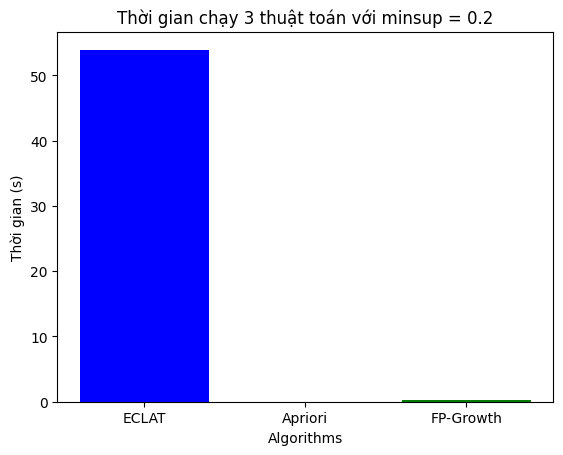

In [ ]:
algorithms = ['ECLAT', 'Apriori', 'FP-Growth']

running_times = [time_eclat, time_apriori, time_fpg]

plt.bar(algorithms, running_times, color=['blue', 'orange', 'green'])

plt.xlabel('Algorithms')
plt.ylabel('Thời gian (s)')
plt.title('Thời gian chạy 3 thuật toán với minsup = 0.2')

plt.show()

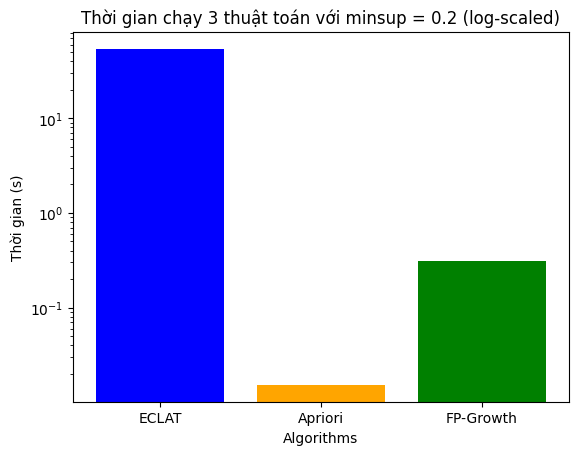

In [ ]:
algorithms = ['ECLAT', 'Apriori', 'FP-Growth']

running_times = [time_eclat, time_apriori, time_fpg]

plt.bar(algorithms, running_times, color=['blue', 'orange', 'green'])

plt.xlabel('Algorithms')
plt.ylabel('Thời gian (s)')
plt.yscale('log')
plt.title('Thời gian chạy 3 thuật toán với minsup = 0.2 (log-scaled)')

plt.show()

In [ ]:
eclat_runtimes = []
apriori_runtimes = []
fpgrowth_runtimes = []

min_support_val = np.linspace(0.1, 0.8, 8)

for val in min_support_val:
    # Eclat
    start_time = time.time()
    eclat.fit(min_support=val, separator=' & ', verbose=True)
    eclat_time = time.time() - start_time
    eclat_runtimes.append(eclat_time)

    # Apriori
    start_time = time.time()
    apriori(df_exp, min_support=val, use_colnames=True)
    apriori_time = time.time() - start_time
    apriori_runtimes.append(apriori_time)

    # FP-Growth
    start_time = time.time()
    fpgrowth(df_exp, min_support=val, use_colnames=True)
    fpgrowth_time = time.time() - start_time
    fpgrowth_runtimes.append(fpgrowth_time)

Combination 1 by 1


38it [00:00, 104.98it/s]


Combination 2 by 2


703it [00:07, 94.83it/s] 


Combination 3 by 3


8436it [00:52, 159.99it/s]


Combination 1 by 1


38it [00:00, 123.62it/s]


Combination 2 by 2


703it [00:04, 158.65it/s]


Combination 3 by 3


8436it [00:49, 169.67it/s]


Combination 1 by 1


38it [00:00, 121.66it/s]


Combination 2 by 2


703it [00:03, 194.94it/s]


Combination 3 by 3


8436it [00:48, 174.22it/s]


Combination 1 by 1


2it [00:00, 109.14it/s]


Combination 2 by 2


1it [00:00, 112.06it/s]


Combination 3 by 3


0it [00:00, ?it/s]


Combination 1 by 1


1it [00:00, 82.29it/s]


Combination 2 by 2


0it [00:00, ?it/s]


Combination 3 by 3


0it [00:00, ?it/s]


Combination 1 by 1


1it [00:00, 61.09it/s]


Combination 2 by 2


0it [00:00, ?it/s]


Combination 3 by 3


0it [00:00, ?it/s]


Combination 1 by 1


1it [00:00, 88.48it/s]


Combination 2 by 2


0it [00:00, ?it/s]


Combination 3 by 3


0it [00:00, ?it/s]


Combination 1 by 1


0it [00:00, ?it/s]


Combination 2 by 2


0it [00:00, ?it/s]


Combination 3 by 3


0it [00:00, ?it/s]


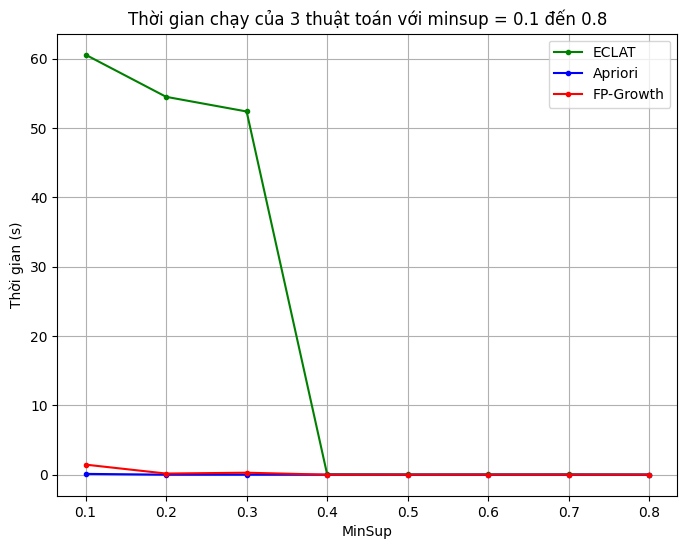

In [ ]:
# Runtimes
plt.figure(figsize=(8, 6))
plt.plot(min_support_val, eclat_runtimes, marker='.', label='ECLAT', color='g')
plt.plot(min_support_val, apriori_runtimes, marker='.', label='Apriori', color='b')
plt.plot(min_support_val, fpgrowth_runtimes, marker='.', label='FP-Growth', color='r')
plt.title('Thời gian chạy của 3 thuật toán với minsup = 0.1 đến 0.8')
plt.xlabel('MinSup')
plt.ylabel('Thời gian (s)')
plt.legend()
plt.grid(True)
plt.show()

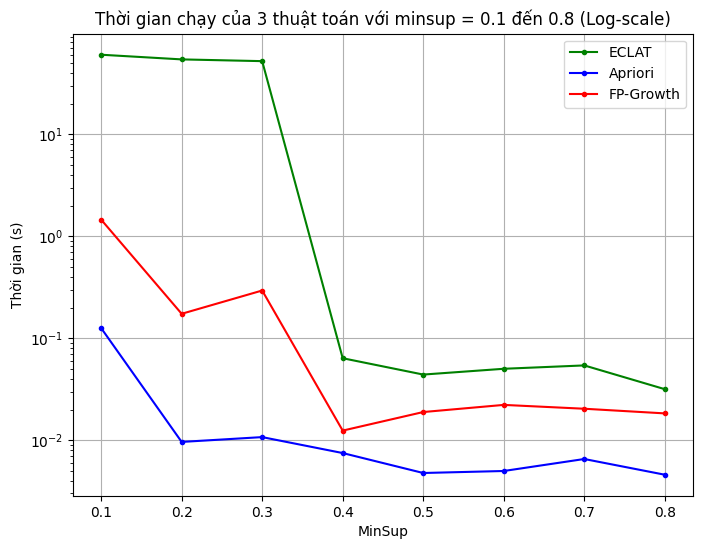

In [ ]:
# Runtimes
plt.figure(figsize=(8, 6))
plt.plot(min_support_val, eclat_runtimes, marker='.', label='ECLAT', color='g')
plt.plot(min_support_val, apriori_runtimes, marker='.', label='Apriori', color='b')
plt.plot(min_support_val, fpgrowth_runtimes, marker='.', label='FP-Growth', color='r')
plt.title('Thời gian chạy của 3 thuật toán với minsup = 0.1 đến 0.8 (Log-scale)')
plt.xlabel('MinSup')
plt.ylabel('Thời gian (s)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# tính support và confidence
support = rules_eclat['support'].to_numpy()
confidence = rules_eclat['confidence'].to_numpy()

In [ ]:
selected_rules = rules_eclat[(rules_eclat['confidence'] > 0.7) & (rules_eclat['support'] > 0.31)]
selected_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(eggs),(vegetables),0.381588,0.726484,0.310874,0.814685,1.121408,0.033656,1.475953,0.175067
34,(poultry),(vegetables),0.408939,0.726484,0.320213,0.783034,1.077841,0.023125,1.260640,0.122185


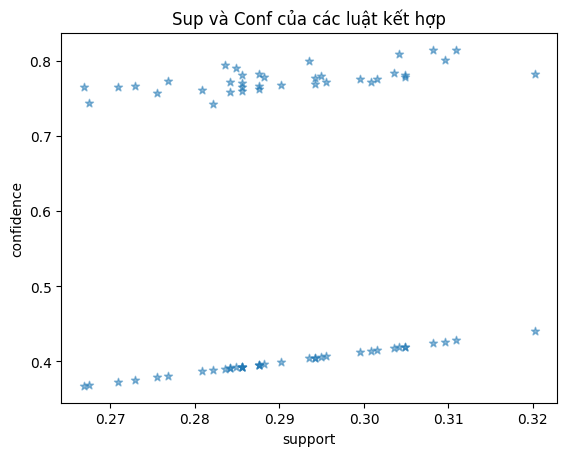

In [ ]:
for i in range(len(support)):
   support[i] = support[i]
   confidence[i] = confidence[i]

plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Sup và Conf của các luật kết hợp')
plt.show()

In [ ]:
# TẠO HÀM (modified) ĐỂ VẼ MỖI LIÊN KẾT GIỮA CÁC LUẬT
# Source: https://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/

def draw_graph(rules, rules_to_show, seed=None):
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np

    if seed is not None:
        np.random.seed(seed)

    G1 = nx.DiGraph()

    color_map = []
    N = 50
    colors = np.random.rand(N)
    strs = ['R'+str(i) for i in range(rules_to_show)]

    for i in range(rules_to_show):
        rule_label = "R"+str(i)
        G1.add_node(rule_label, color='yellow', size=700)

        for a in rules.iloc[i]['antecedents']:
            G1.add_node(a, color='green', size=300)
            G1.add_edge(a, rule_label, color=colors[i], weight=2)

        for c in rules.iloc[i]['consequents']:
            G1.add_node(c, color='green', size=300)
            G1.add_edge(rule_label, c, color=colors[i], weight=2)

    pos = nx.spring_layout(G1, k=1, scale=1)
    for node in G1.nodes:
        color_map.append(G1.nodes[node]['color'])

    edges = G1.edges()
    edge_colors = [G1[u][v]['color'] for u, v in edges]
    weights = [G1[u][v]['weight'] for u, v in edges]

    nx.draw(G1, pos, node_color=color_map, edge_color=edge_colors, width=weights, node_size=[G1.nodes[node]['size'] for node in G1], with_labels=False)

    for p in pos:
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)

    plt.show()

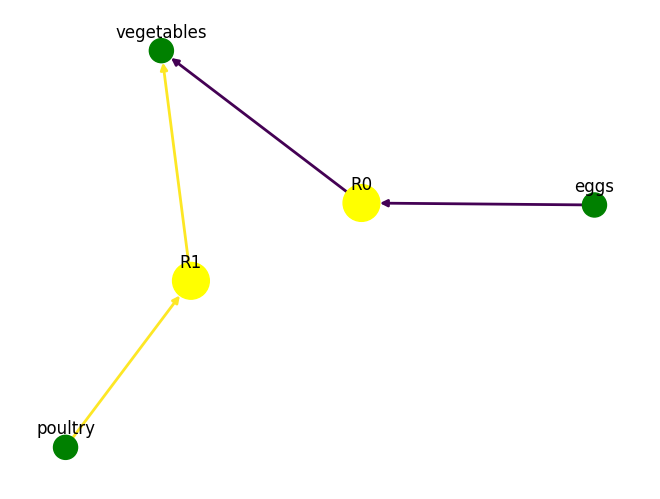

In [ ]:
# stickman
# Vẽ luật kết hợp tập luật đã chọn:
draw_graph(selected_rules, 2, 42)

In [ ]:
# def find_rules(rules, item1, item2):
#     filtered_rules = rules[
#         (rules['antecedents'].apply(lambda x: item1 in x or item2 in x)) &
#         (rules['consequents'].apply(lambda x: item1 in x or item2 in x))
#     ]
#     return filtered_rules

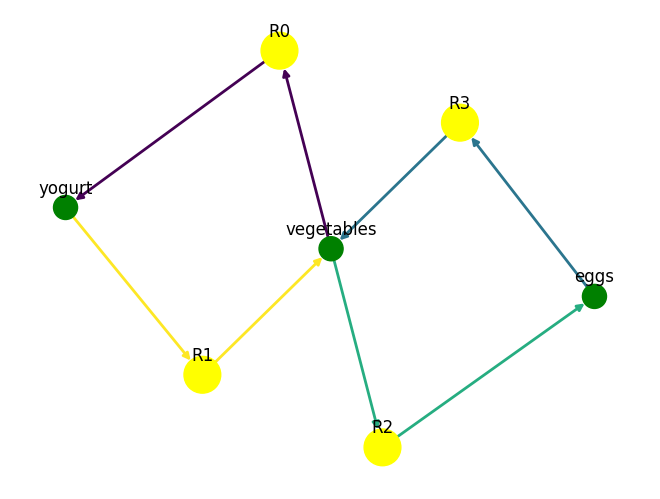

In [ ]:
# Vẽ các tập luật có lift cao nhất:
draw_graph(rules_eclat, 4, 42)

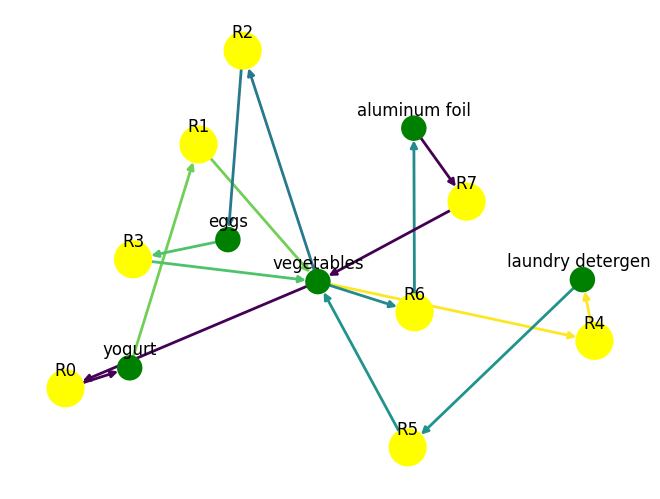

In [ ]:
# gáng nhìn nha
draw_graph(rules_eclat, 8, 7)